# Variational Autoencoder for Audio
In this notebook, I will attempt to implement a VAE for generating similar sounds as those in a Spoken Digit audio Database. 

In [22]:
%matplotlib inline
import IPython.display

import gzip
import cPickle as pickle
import pandas as pd
import random
import seaborn
import librosa

from librosa.display import waveplot, specshow
seaborn.set(style='ticks')

In [2]:
dbfile ='SpokenDigitDB.pkl.gz'
with gzip.open(dbfile, 'rb') as ifile:
    df = pickle.load(ifile)
    print('File loaded as '+ dbfile)    

File loaded as SpokenDigitDB.pkl.gz


(array([  52.,  114.,  106.,   80.,   46.,   58.,   21.,    7.,    7.,   10.]),
 array([  44. ,   50.6,   57.2,   63.8,   70.4,   77. ,   83.6,   90.2,
          96.8,  103.4,  110. ]),
 <a list of 10 Patch objects>)

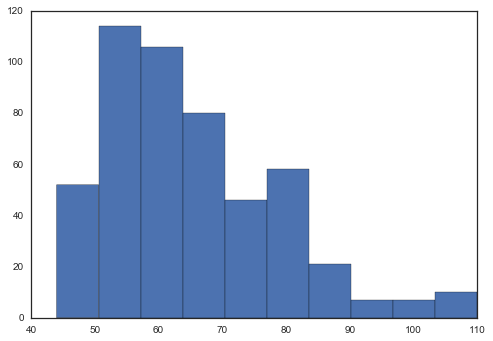

In [38]:
# mag = df.Magnitude
# map(np.shape,mag)
plt.hist([np.shape(x)[1] for x in mag])

## Plot Samples from Database

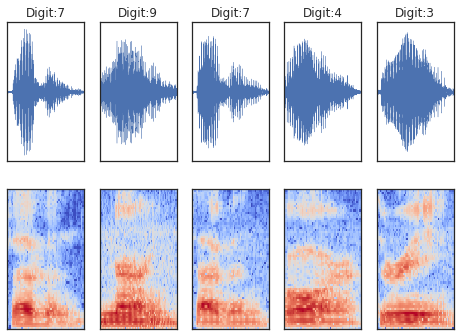

In [35]:
seaborn.set(style='white')

# Plot K Random Examples
k  = 5
sr = 8000

sidx = random.sample(range(len(df)),k)
sidx = np.append(sidx,sidx)    

for i,j in enumerate(sidx):
    if i<k:
        subplot(2,k,i+1)
        waveplot(df.Wave[j],sr=sr)
        title('Digit:{1}'.format(j,df.Class[j]))
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().get_xaxis().set_visible(False)

    else:
        subplot(2,k,i+1)
        specshow(df.Magnitude[j],sr=sr)
        gca().set_xticklabels([])
        gca().set_yticklabels([]) 

In [37]:
# Play back an example!
j = sidx[0]
IPython.display.Audio(data=df.Wave[j], rate=sr)

## VAE for Audio